Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Medical Image Classification Tutorial with the MedNIST Dataset

In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.

We'll go through the following steps:
* Create a dataset for training and testing
* Use MONAI transforms to pre-process data
* Use the DenseNet from MONAI for classification
* Train the model with a PyTorch program
* Evaluate on test dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)

## Setup environment

In [2]:
# !python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

/bin/bash: python: command not found


^C
ERROR: Operation cancelled by user
/bin/bash: python: command not found


## Setup imports

In [1]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from PIL import Image


from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.data import pad_list_data_collate
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

/home/pralambang/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-15 11:31:29.201865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 11:31:30.626345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 11:31:33.125564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


MONAI version: 1.3.dev2341
Numpy version: 1.24.3
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5e961b825584160b868d856ce57624c7dce10f04
MONAI __file__: /home/<username>/.local/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 7.0.0
Tensorboard version: 2.13.0
gdown version: 4.7.1
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.7.1
pynrrd version: 1.0.0
clearml version: 1.13.2rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get('MONAI_DATA_DIRECTORY')
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp6rkiyza0


## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

In [3]:
# resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
# md5 = "0bc7306e7427e00ad1c5526a6677552d"

# compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
# data_dir = os.path.join(root_dir, "MedNIST")
# if not os.path.exists(data_dir):
#     download_and_extract(resource, compressed_file, root_dir, md5)

## Set deterministic training for reproducibility

In [4]:
set_determinism(seed=0)

In [5]:
data_dir = '/home/pralambang/Documents/Foto_resized_gray/'

In [6]:
from PIL import Image
import os

def resize_and_gray_images(input_dir, output_dir, target_width, target_height):
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, relative_path)
                
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                
                with Image.open(input_path) as img:
                    resized_img = img.resize((target_width, target_height), Image.ANTIALIAS)
                    grayscale_img = resized_img.convert('L')
                    grayscale_img.save(output_path)

# Define the input directory, output directory, target width, and target height
input_dir = '/home/pralambang/Documents/Foto'
output_dir = '/home/pralambang/Documents/Foto_resized_gray'
target_width = 385
target_height = 385

# Call the function to resize images and convert to grayscale
resize_and_gray_images(input_dir, output_dir, target_width, target_height)


In [7]:
# from PIL import Image
# import os

# def resize_images(input_dir, output_dir, target_width, target_height):
#     for root, dirs, files in os.walk(input_dir):
#         for file in files:
#             if file.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
#                 input_path = os.path.join(root, file)
#                 relative_path = os.path.relpath(input_path, input_dir)
#                 output_path = os.path.join(output_dir, relative_path)
                
#                 os.makedirs(os.path.dirname(output_path), exist_ok=True)
                
#                 with Image.open(input_path) as img:
#                     resized_img = img.resize((target_width, target_height), Image.ANTIALIAS)
#                     resized_img.save(output_path)

# # Define the input directory, output directory, target width, and target height
# input_dir = '/home/pralambang/Documents/Foto'
# output_dir = '/home/pralambang/Documents/Foto_resized'
# target_width = 385
# target_height = 385

# # Call the function to resize images
# resize_images(input_dir, output_dir, target_width, target_height)


## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which should be used as the labels to train our classification model.

In [8]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 124
Image dimensions: 385 x 385
Label names: ['Aneuploid', 'Euploid']
Label counts: [63, 61]


## Randomly pick images from the dataset to visualize and check

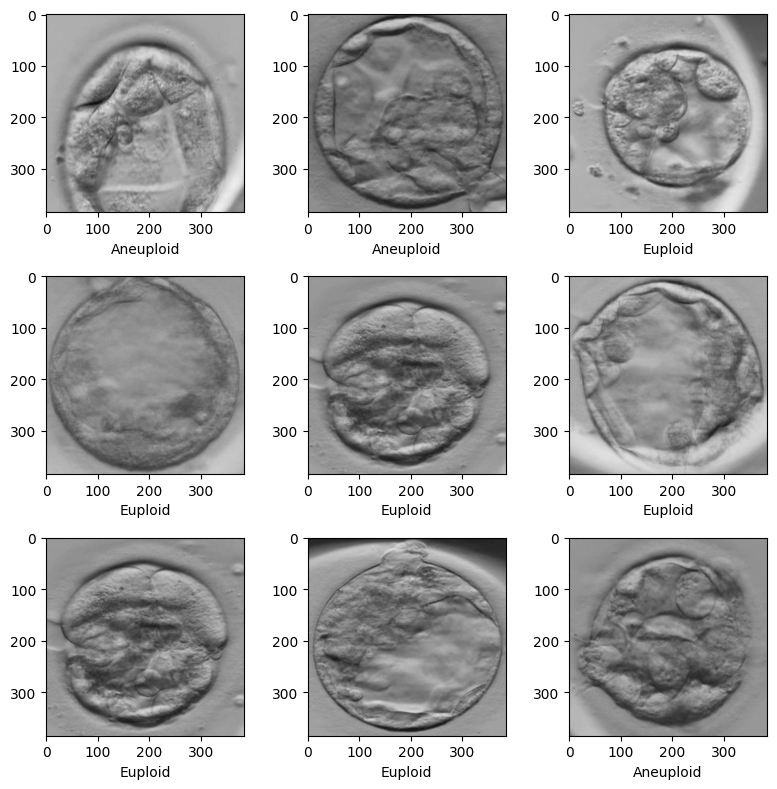

In [9]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [10]:
val_frac = 0.2
test_frac = 0.2
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 76, Validation count: 24, Test count: 24


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [11]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [12]:
def load_and_convert_to_gray(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

train_transforms = Compose(
    [
        LoadImage(image_only=True, reader=lambda x: load_and_convert_to_gray(x)),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True, reader=lambda x: load_and_convert_to_gray(x)),
        EnsureChannelFirst(),
        ScaleIntensity(),
    ]
)

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

Preferably the reader should inherit ImageReader, but got <class 'function'>.


In [13]:
class EmbrioDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]




train_ds = EmbrioDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=50, shuffle=True, num_workers=5, collate_fn=pad_list_data_collate)

val_ds = EmbrioDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=50, num_workers=5, collate_fn=pad_list_data_collate)

test_ds = EmbrioDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=50, num_workers=5, collate_fn=pad_list_data_collate)

## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)


## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [15]:
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []

# for epoch in range(max_epochs):
#     print("-" * 10)
#     print(f"epoch {epoch + 1}/{max_epochs}")
#     model.train()
#     epoch_loss = 0
#     step = 0
#     for batch_data in train_loader:
#         step += 1
#         inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = loss_function(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#         print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
#         epoch_len = len(train_ds) // train_loader.batch_size
#     epoch_loss /= step
#     epoch_loss_values.append(epoch_loss)
#     print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         with torch.no_grad():
#             y_pred = torch.tensor([], dtype=torch.float32, device=device)
#             y = torch.tensor([], dtype=torch.long, device=device)
#             for val_data in val_loader:
#                 val_images, val_labels = (
#                     val_data[0].to(device),
#                     val_data[1].to(device),
#                 )
#                 y_pred = torch.cat([y_pred, model(val_images)], dim=0)
#                 y = torch.cat([y, val_labels], dim=0)
#             y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
#             y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
#             auc_metric(y_pred_act, y_onehot)
#             result = auc_metric.aggregate()
#             auc_metric.reset()
#             del y_pred_act, y_onehot
#             metric_values.append(result)
#             acc_value = torch.eq(y_pred.argmax(dim=1), y)
#             acc_metric = acc_value.sum().item() / len(acc_value)
#             if result > best_metric:
#                 best_metric = result
#                 best_metric_epoch = epoch + 1
#                 torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
#                 print("saved new best metric model")
#             print(
#                 f"current epoch: {epoch + 1} current AUC: {result:.4f}"
#                 f" current accuracy: {acc_metric:.4f}"
#                 f" best AUC: {best_metric:.4f}"
#                 f" at epoch: {best_metric_epoch}"
#             )

# print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

In [17]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
false_positives = []
false_negatives = []
all_true_labels = []
all_pred_labels = []


for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                
                #--edit 2
                y_pred = model(val_images)

                y_true = y_trans(val_labels.cpu())  # Adjust if necessary to match your data format
                y_pred_labels = y_pred_trans(y_pred.cpu()).argmax(dim=1)  # Adjust if necessary to match your data format

                fp_indices = (y_true == 0) & (y_pred_labels == 1)
                fn_indices = (y_true == 1) & (y_pred_labels == 0)
                
                false_positives.extend(val_images[fp_indices].cpu().numpy())
                false_negatives.extend(val_images[fn_indices].cpu().numpy())

                #--


            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            #Editan--
            cm = confusion_matrix(y.cpu().numpy(), y_pred.argmax(dim=1).cpu().numpy())
            print(f'Confusion Matrix for epoch {epoch + 1}:\n{cm}')
            all_true_labels.extend(y.cpu().numpy())
            all_pred_labels.extend(y_pred.argmax(dim=1).cpu().numpy())
            #--
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")


----------
epoch 1/4


1/1, train_loss: 0.6936
2/1, train_loss: 0.6825
epoch 1 average loss: 0.6880


RuntimeError: applying transform <monai.transforms.post.array.AsDiscrete object at 0x7fa05cfcddf0>

In [ ]:
overall_cm = confusion_matrix(all_true_labels, all_pred_labels)
print(f'Overall Confusion Matrix:\n{overall_cm}')

Overall Confusion Matrix:
[[ 2 38]
 [ 4 52]]


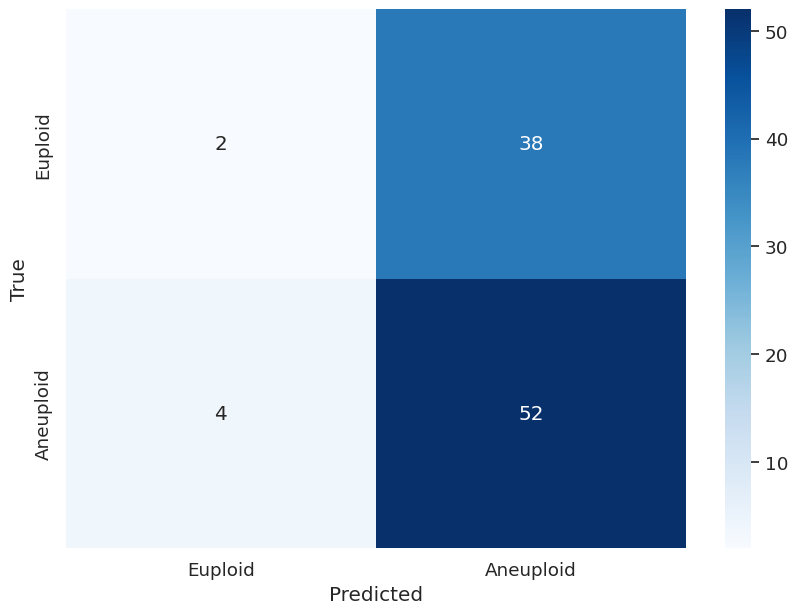

In [ ]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # for label size
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Euploid', 'Aneuploid'],
                yticklabels=['Euploid', 'Aneuploid'])  # font size
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Assuming overall_cm is your confusion matrix
plot_confusion_matrix(overall_cm)


In [ ]:
# Assuming val_images is your array of validation images
false_positives = [val_images[i] for i, (true, pred) in enumerate(zip(all_true_labels, all_pred_labels)) if true == 0 and pred == 1]
false_negatives = [val_images[i] for i, (true, pred) in enumerate(zip(all_true_labels, all_pred_labels)) if true == 1 and pred == 0]


IndexError: index 24 is out of bounds for dimension 0 with size 24

## Plot the loss and metric

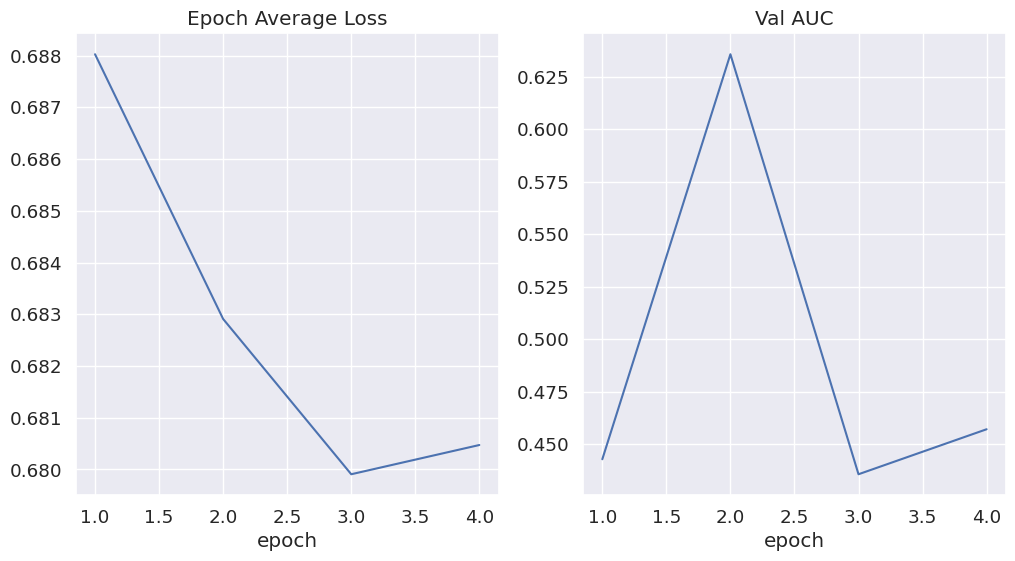

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   Aneuploid     0.0000    0.0000    0.0000        16
     Euploid     0.3333    1.0000    0.5000         8

    accuracy                         0.3333        24
   macro avg     0.1667    0.5000    0.2500        24
weighted avg     0.1111    0.3333    0.1667        24



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)